<h1><center><font color="#38590f">How Does a Bike-Share Navigate Speedy Success?</font></center></h1>

<h2><center><font color="grey">(Case Study #1)</font></center></h2>

<h3><font color="purple">Packages</font></h3>

In [1]:
# Analysis
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

<h3><font color="purple">Import Data</font></h3>

##### Read data from CSV

In [2]:
files = [
    "datasets/202201-divvy-tripdata.csv", 
    "datasets/202202-divvy-tripdata.csv", 
    "datasets/202203-divvy-tripdata.csv", 
    "datasets/202204-divvy-tripdata.csv", 
    "datasets/202205-divvy-tripdata.csv", 
    "datasets/202206-divvy-tripdata.csv", 
    "datasets/202207-divvy-tripdata.csv", 
    "datasets/202208-divvy-tripdata.csv", 
    "datasets/202209-divvy-tripdata.csv", 
    "datasets/202210-divvy-tripdata.csv", 
    "datasets/202211-divvy-tripdata.csv", 
    "datasets/202212-divvy-tripdata.csv"]

data = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)

##### Sample

In [3]:
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.01,-87.67,42.01,-87.67,casual
1,A6CF8980A652D272,electric_bike,2022-01-10 08:41:56,2022-01-10 08:46:17,Glenwood Ave & Touhy Ave,525,Clark St & Touhy Ave,RP-007,42.01,-87.67,42.01,-87.67,casual
2,BD0F91DFF741C66D,classic_bike,2022-01-25 04:53:40,2022-01-25 04:58:01,Sheffield Ave & Fullerton Ave,TA1306000016,Greenview Ave & Fullerton Ave,TA1307000001,41.93,-87.65,41.93,-87.67,member
3,CBB80ED419105406,classic_bike,2022-01-04 00:18:04,2022-01-04 00:33:00,Clark St & Bryn Mawr Ave,KA1504000151,Paulina St & Montrose Ave,TA1309000021,41.98,-87.67,41.96,-87.67,casual
4,DDC963BFDDA51EEA,classic_bike,2022-01-20 01:31:10,2022-01-20 01:37:12,Michigan Ave & Jackson Blvd,TA1309000002,State St & Randolph St,TA1305000029,41.88,-87.62,41.88,-87.63,member


<h3><font color="purple">Raw Data Description</font></h3>

##### General info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5667717 entries, 0 to 5667716
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 562.1+ MB


##### Empty rows

In [5]:
missing_rows_percent = (data.shape[0] - data.dropna().shape[0]) / data.shape[0] * 100
print(f"Here are {missing_rows_percent:.2f}% of incomplete rows")

Here are 22.91% of incomplete rows


##### Check typos in sets of values

In [6]:
data["rideable_type"].unique()

array(['electric_bike', 'classic_bike', 'docked_bike'], dtype=object)

In [7]:
data["member_casual"].unique()

array(['casual', 'member'], dtype=object)

<h3><font color="purple">Data Cleaning (Changelog)</font></h3>

##### 1. Get rid of cols about station id and coordinates (are not used in this analysis)

In [8]:
data = data.drop(columns=["start_station_id", "end_station_id", "start_lat", "start_lng", "end_lat", "end_lng"])

##### 2. Get rid of rows with empty cells

In [9]:
data = data.dropna()
data.isnull().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
end_station_name      0
member_casual         0
dtype: int64

##### 3. Set datetime type explicitly

In [10]:
data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])

##### 4. Data sample after cleaning

In [11]:
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual
0,C2F7DD78E82EC875,electric_bike,2022-01-13 11:59:47,2022-01-13 12:02:44,Glenwood Ave & Touhy Ave,Clark St & Touhy Ave,casual
1,A6CF8980A652D272,electric_bike,2022-01-10 08:41:56,2022-01-10 08:46:17,Glenwood Ave & Touhy Ave,Clark St & Touhy Ave,casual
2,BD0F91DFF741C66D,classic_bike,2022-01-25 04:53:40,2022-01-25 04:58:01,Sheffield Ave & Fullerton Ave,Greenview Ave & Fullerton Ave,member
3,CBB80ED419105406,classic_bike,2022-01-04 00:18:04,2022-01-04 00:33:00,Clark St & Bryn Mawr Ave,Paulina St & Montrose Ave,casual
4,DDC963BFDDA51EEA,classic_bike,2022-01-20 01:31:10,2022-01-20 01:37:12,Michigan Ave & Jackson Blvd,State St & Randolph St,member


<h3><font color="purple">Data Transformation</font></h3>

##### 1. Add separate columns about date and time

In [12]:
# Start
data["start_time"] = data["started_at"].dt.time
data["start_date"] = data["started_at"].dt.date

# End
data["end_time"] = data["ended_at"].dt.time
data["end_date"] = data["ended_at"].dt.date

##### 2. Add trip route

In [13]:
data["trip_route"] = data["start_station_name"] + " to " + data["end_station_name"]

##### 3. Add trip duration (in minutes)

In [14]:
data["trip_duration_minutes"] = (data["ended_at"] - data["started_at"]).dt.total_seconds() / 60

##### 4. Exclude rows with negative trip duration

In [15]:
length_before = data.shape[0]
print(f"Dataset length before: {length_before}")

Dataset length before: 4369360


In [16]:
time_error_rows = data[data["trip_duration_minutes"] < 0]
data = data[~data["ride_id"].isin(time_error_rows["ride_id"])]

In [17]:
length_after = data.shape[0]
print(f"Dataset length after: {length_after}")

Dataset length after: 4369291


##### 5. Get rid of extra columns

In [18]:
data = data.drop(columns=["started_at", "ended_at", "start_station_name", "end_station_name"])

##### 6. Add distinct column about hours

In [19]:
data["hour"] = data.apply(lambda time: time["start_time"].hour, axis=1)

In [20]:
data["start_date"] = pd.to_datetime(data["start_date"])
data["month"] = data["start_date"].dt.month_name()

##### 7. Prepared Data Sample

In [21]:
data.head()

,ride_id,rideable_type,member_casual,start_time,start_date,end_time,end_date,trip_route,trip_duration_minutes,hour,month
0,C2F7DD78E82EC875,electric_bike,casual,11:59:47,2022-01-13,12:02:44,2022-01-13,Glenwood Ave & Touhy Ave to Clark St & Touhy Ave,2.95,11,January
1,A6CF8980A652D272,electric_bike,casual,08:41:56,2022-01-10,08:46:17,2022-01-10,Glenwood Ave & Touhy Ave to Clark St & Touhy Ave,4.35,8,January
2,BD0F91DFF741C66D,classic_bike,member,04:53:40,2022-01-25,04:58:01,2022-01-25,Sheffield Ave & Fullerton Ave to Greenview Ave...,4.35,4,January
3,CBB80ED419105406,classic_bike,casual,00:18:04,2022-01-04,00:33:00,2022-01-04,Clark St & Bryn Mawr Ave to Paulina St & Montr...,14.93,0,January
4,DDC963BFDDA51EEA,classic_bike,member,01:31:10,2022-01-20,01:37:12,2022-01-20,Michigan Ave & Jackson Blvd to State St & Rand...,6.03,1,January


<h3><font color="purple">Data Analysis</font></h3>

#### 1. Percent of casual riders and members 

In [22]:
data["member_casual"].value_counts(normalize=True) * 100

member   59.76
casual   40.24
Name: member_casual, dtype: float64

#### 2. Preferences in rideable type

##### - General preferences

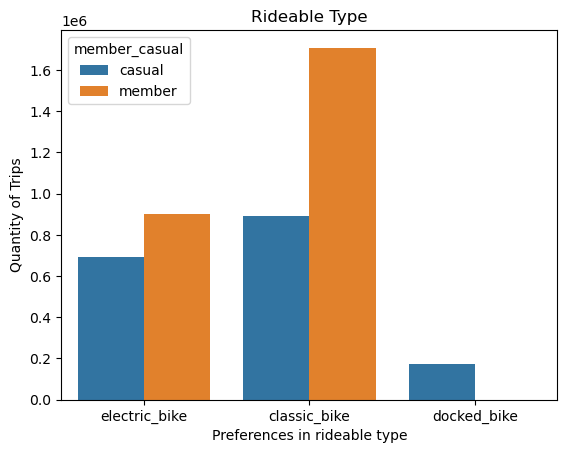

In [23]:
ax = sns.countplot(data=data, x="rideable_type", hue="member_casual")

ax.set(xlabel="Preferences in rideable type",
       ylabel="Quantity of Trips",
       title="Rideable Type")

plt.show()

##### - Classic bike preferences (members)

In [24]:
data[data["member_casual"] == "member"]["rideable_type"].value_counts(normalize=True) * 100

classic_bike    65.44
electric_bike   34.56
Name: rideable_type, dtype: float64

##### - Classic bike preferences (casual riders)

In [25]:
data[data["member_casual"] == "casual"]["rideable_type"].value_counts(normalize=True) * 100

classic_bike    50.55
electric_bike   39.50
docked_bike      9.95
Name: rideable_type, dtype: float64

##### 3. Trip duration for different types of riders

##### - General comparison

In [26]:
stats = data[["member_casual", "trip_duration_minutes"]] \
.groupby(["member_casual"]) \
.agg({"trip_duration_minutes": ["mean", "std", "max", "min"]}).reset_index()

stats.columns =  stats.columns.droplevel()
stats = stats.rename(columns={'': "member_casual"})
stats

,member_casual,mean,std,max,min
0,casual,23.99,71.25,34354.07,0.00
1,member,12.45,19.03,1493.23,0.00


In [36]:
casual_rider_mean = stats[stats["member_casual"] == "casual"]["mean"].values[0]
member_mean = stats[stats["member_casual"] == "member"]["mean"].values[0]

diff = casual_rider_mean / member_mean

print(f"Casual riders' trips are {diff:.2f} times longer than members' trips")

Casual riders' trips are 1.93 times longer than members' trips


##### 4. Preferred routes

In [28]:
# Count quantity of trips for every route
routes = data[["member_casual", "trip_route", "ride_id"]] \
.groupby(["member_casual", "trip_route"]) \
.agg({"ride_id": ["count"]}).reset_index()

# Get the most popular routes for every type of customer
routes["count"] = routes["ride_id"]["count"] # get rid of extra layer in index
routes = routes[["member_casual", "trip_route", "count"]].sort_values(by="count", ascending=False) # sorting
routes = routes.groupby("member_casual").head(10) # first 10 for every type

##### - Preferred routes of casual riders

In [29]:
routes[routes["member_casual"] == "casual"][["trip_route", "count"]]

,trip_route,count
,,
116367,Streeter Dr & Grand Ave to Streeter Dr & Grand...,10631
42714,DuSable Lake Shore Dr & Monroe St to DuSable L...,6615
42939,DuSable Lake Shore Dr & Monroe St to Streeter ...,5100
80749,Michigan Ave & Oak St to Michigan Ave & Oak St,4612
82604,Millennium Park to Millennium Park,4060
84539,Montrose Harbor to Montrose Harbor,2939
116106,Streeter Dr & Grand Ave to DuSable Lake Shore ...,2854
116252,Streeter Dr & Grand Ave to Millennium Park,2735
103722,Shedd Aquarium to Shedd Aquarium,2479


##### - Preferred routes of members

In [30]:
routes[routes["member_casual"] == "member"][["trip_route", "count"]]

,trip_route,count
,,
180995,Ellis Ave & 60th St to University Ave & 57th St,5848
257660,University Ave & 57th St to Ellis Ave & 60th St,5544
180923,Ellis Ave & 60th St to Ellis Ave & 55th St,5278
180694,Ellis Ave & 55th St to Ellis Ave & 60th St,4745
251913,State St & 33rd St to Calumet Ave & 33rd St,3268
149225,Calumet Ave & 33rd St to State St & 33rd St,3215
212872,Loomis St & Lexington St to Morgan St & Polk St,2891
223865,Morgan St & Polk St to Loomis St & Lexington St,2876
257681,University Ave & 57th St to Kimbark Ave & 53rd St,2267


##### 5. Time preferences 

##### - Calculate statistic about rush hours

In [31]:
hours_stat = data[["hour", "member_casual"]].groupby(["member_casual", "hour"]).agg({"hour": ["count"]}).reset_index()

hours_stat.columns = hours_stat.columns.droplevel()
hours_stat.columns.values[0] = "member_casual"
hours_stat.columns.values[1] = "hour"

##### - Rush Hour Visualization

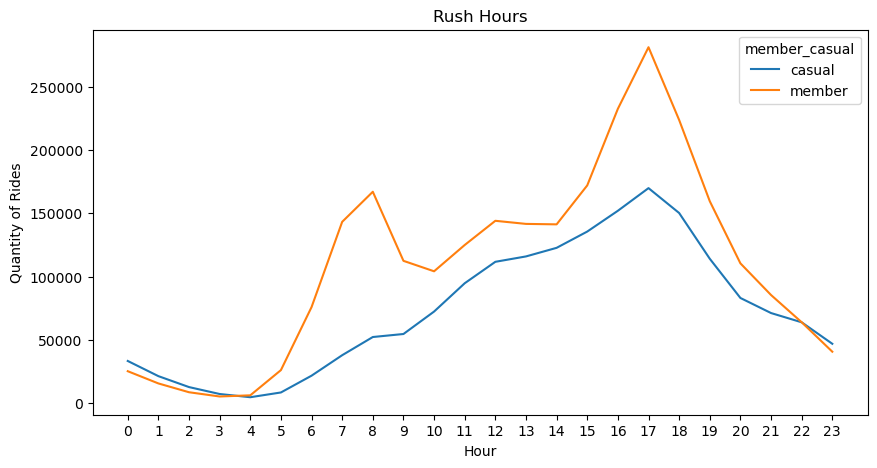

In [32]:
plt.figure(figsize=(10, 5))

ax = sns.lineplot(data=hours_stat, x = "hour", y = "count", hue = "member_casual")

ax.set(xlabel="Hour",
       ylabel="Quantity of Rides",
       xticks = np.arange(data["hour"].min(), data["hour"].max() + 1, 1.0),
       title="Rush Hours")

plt.show()

##### 6. Seasonality

##### - Calculate statistics about seasonality

In [33]:
months_stat = data[["month", "member_casual"]].groupby(["member_casual", "month"]).agg({"month": ["count"]}).reset_index()

months_stat.columns = months_stat.columns.droplevel()
months_stat.columns.values[0] = "member_casual"
months_stat.columns.values[1] = "month"

months_stat.sort_values(by="month")

,member_casual,month,count
0,casual,April,91897
12,member,April,180663
1,casual,August,270089
13,member,August,335224
2,casual,December,31505
14,member,December,103898
3,casual,February,15144
15,member,February,74034
4,casual,January,12605
16,member,January,67523


##### - Ordering by month

In [34]:
months_ordered = ["January", 
          "February", 
          "March", 
          "April", 
          "May", 
          "June", 
          "July", 
          "August", 
          "September", 
          "October", 
          "November", 
          "December"]

months_stat["month"] = pd.Categorical(months_stat["month"], months_ordered)

##### - Seasonality visualization

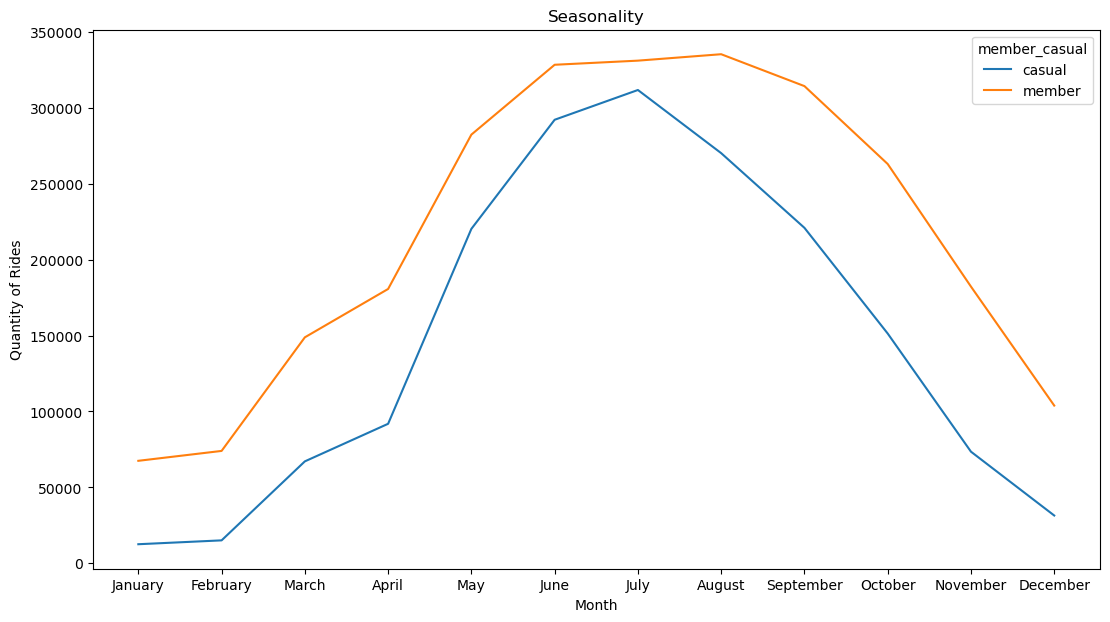

In [35]:
plt.figure(figsize=(13, 7))

ax = sns.lineplot(data=months_stat, x = "month", y = "count", hue = "member_casual")

ax.set(xlabel="Month",
       ylabel="Quantity of Rides",
       title="Seasonality")

plt.show()